# OpenSecrets: Personal Finance Data
Data source: https://www.opensecrets.org/bulk-data/downloads  
Documentations: https://www.opensecrets.org/resources/datadictionary/Data%20Dictionary%20pfd_trans.htm

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode

## Raw Data

In [2]:
with open("../data/pfd/PFDtrans.txt") as f: 
    for _ in range(2):
        print(f.readline())

|A170015889|,|s|,|N00009888|,|17|,|Y|,|S|,|Tortoise MLP & Pipeline Instl|,|Tortoise MLP & Pipeline Fund|,||,||,||,||,||,||,||,||,|x|,| |,| |,,|09/29/2017|,|C |,,| |,|--|,|d|

|A170015888|,|s|,|N00009888|,|17|,|Y|,|S|,|Vanguard Dividend Appreciation ETF|,|Vanguard Dividend Appreciation ETF|,||,||,||,||,||,||,||,||,|x|,| |,| |,,|07/19/2017|,|C |,,| |,|--|,|d|



## Processed Data
The data is processed to format as a tab delimited file. Processed using shell script `data/process_pfd.sh`. 

In [3]:
pfd_colnames=['ID', 'Chamber', 'CID', 'CalendarYear', 'ReportType', 'Asset4SJD', 'Asset4Transacted', 'Orgname', 'Ultorg', 'RealCode', 'Source', 'Asset4Descrip', 'Orgname2', 'Ultorg2', 'RealCode2', 'Source2', 'Asset4Purchased', 'Asset4Sold', 'Asset4Exchanged', 'Asset4Date', 'Asset4DateText', 'Asset4TransAmt', 'Asset4ExactAmt', 'CofD', 'TransNotes', 'Dupe'] 
pfd = pd.read_csv("../data/pfd/PFDtrans_test2.txt", encoding="latin-1", sep="\t", names=pfd_colnames, header=None)
pfd

C:\Users\Yiyan\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,8,11,13,22,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ID,Chamber,CID,CalendarYear,ReportType,Asset4SJD,Asset4Transacted,Orgname,Ultorg,RealCode,...,Asset4Purchased,Asset4Sold,Asset4Exchanged,Asset4Date,Asset4DateText,Asset4TransAmt,Asset4ExactAmt,CofD,TransNotes,Dupe
0,A170015889,s,N00009888,17,Y,S,Tortoise MLP & Pipeline Instl,Tortoise MLP & Pipeline Fund,NaN,NaN,...,x,,,NaN,09/29/2017,C,NaN,,--,d
1,A170015888,s,N00009888,17,Y,S,Vanguard Dividend Appreciation ETF,Vanguard Dividend Appreciation ETF,NaN,NaN,...,x,,,NaN,07/19/2017,C,NaN,,--,d
2,A170015887,s,N00009888,17,Y,S,UBS ETRACS Alerian MLP Infras ETN,UBS ETRACS Alerian MLP Infras ETN,NaN,NaN,...,x,,,NaN,07/19/2017,C,NaN,,--,d
3,A170015886,s,N00009888,17,Y,S,Tortoise MLP & Pipeline Instl,Tortoise MLP & Pipeline Fund,NaN,NaN,...,x,,,NaN,07/17/2017,C,NaN,,--,d
4,A170015885,s,N00009888,17,Y,S,DTC US Active Equity Common Trust Fund,DTC US Active Equity Common Trust Fund,NaN,NaN,...,x,,,NaN,07/07/2017,E,NaN,,--,d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377663,C160015720,s,N00030245,16,A,S,Oakmark Equity And Income Investor,Oakmark Equity & Income Fund,NaN,NaN,...,,x,,NaN,10/31/2016,B,NaN,,Sale (Full),d
377664,C160015719,s,N00030245,16,A,S,Oakmark Equity And Income Investor,Oakmark Equity & Income Fund,NaN,NaN,...,,x,,NaN,03/28/2016,B,NaN,,Sale (Partial),d
377665,C160015718,s,N00030245,16,A,S,First Eagle Global I,First Eagle Global Fund,NaN,NaN,...,,x,,NaN,10/31/2016,B,NaN,,Sale (Partial),d
377666,C160015717,s,N00030245,16,A,S,First Eagle Global I,First Eagle Global Fund,NaN,NaN,...,,x,,NaN,03/28/2016,B,NaN,,Sale (Partial),d


In [ ]:
# pfd.to_csv("../data/pfd_clean/PFD_trans.csv", index=False)

Many entries in `Asset4Date` are missing while `Asset4DateText` contains valid values. Copy values from `Asset4DateText` over to `Asset4Date`

In [4]:
filled_dates = pfd["Asset4Date"].copy()
for i in range(len(filled_dates)):
    if filled_dates[i] != filled_dates[i]:
        filled_dates[i] = pfd["Asset4DateText"][i]
pfd["Asset4Date"] = filled_dates

Convert all `Asset4Date` into `datetime` objects if possible. 

In [5]:
def process_date_text(text):
    if type(text) == float:
        return np.nan
    else:
        try: 
            return datetime.strptime(text, '%m/%d/%Y')
        except: 
            return np.nan
v_process_date_text = np.vectorize(process_date_text)

In [6]:
datetime_lst = v_process_date_text(pfd["Asset4Date"])

## Preliminary Exploration

#### Total number of transactions recorded in the raw dataset

In [7]:
len(datetime_lst)

377668

#### Number of transactions that contains valid transaction dates

In [8]:
len(datetime_lst[~pd.isnull(datetime_lst)])

317565

In [9]:
len(datetime_lst[~pd.isnull(datetime_lst)]) / len(datetime_lst)

0.8408575786140208

In [10]:
# what are the invalid ones
pfd["Asset4Date"][pd.isnull(datetime_lst)].dropna()

1067                02/21/217
2497                02/21/217
3512            Semi-annually
3513                Quarterly
3514                Quarterly
                 ...         
376875    Mar  7 2017 12:00AM
376876    Jan 10 2017 12:00AM
376877    Jan 10 2017 12:00AM
376878    Nov 15 2017 12:00AM
376879    May 15 2017 12:00AM
Name: Asset4Date, Length: 42901, dtype: object

#### Earliest and Lastest data entries

In [11]:
max(datetime_lst[~pd.isnull(datetime_lst)]) # obvious data entry error

datetime.datetime(2107, 4, 12, 0, 0)

In [12]:
min(datetime_lst[~pd.isnull(datetime_lst)])

datetime.datetime(1930, 5, 15, 0, 0)

#### Histograms

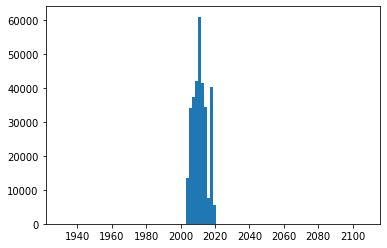

In [13]:
plt.hist(datetime_lst[~pd.isnull(datetime_lst)], bins=100);

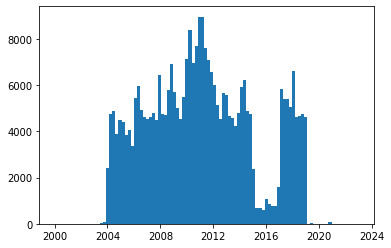

In [14]:
plt.hist(datetime_lst[~pd.isnull(datetime_lst)], range=[datetime(2000, 1, 1, 0, 0), datetime(2022, 12, 31, 0, 0)], bins=100);

### Stock Data

In [15]:
# TODO
# pfd_asset = pd.read_csv("../data/pfd/PFDasset_test2.txt", encoding="latin-1", sep="\t", names=pfd_colnames, header=None)
# pfd_asset

## API PFD Profiles

In [18]:
class Pfdprofile:
    api_key = "2b52e9adf0c585e4209767a9d4bb45a4"
    
    def __init__(self, year, cid):
        data_type = "json"
        endpoint = f"https://www.opensecrets.org/api/"
        params = {"method": "memPFDprofile", "year": year, "cid": cid, "output": data_type, "apikey": self.api_key}
        url_params = urlencode(params)

        self.url = f"{endpoint}?{url_params}"

        r = requests.get(self.url)
        if r.status_code not in range(200, 299):
            self.data = {}
        self.data = r.json()["response"]
        
    def print_data(self):
        return self.data
    
    def get_profile(self):
        return self.data['member_profile']['@attributes']

In [19]:
profile = Pfdprofile(2016, "N00007360")

In [20]:
profile.get_profile()

{'name': 'Pelosi, Nancy',
 'data_year': '2016',
 'member_id': 'N00007360',
 'net_low': '-16225953',
 'net_high': '139050988',
 'positions_held_count': '0',
 'asset_count': '44',
 'asset_low': '32824047',
 'asset_high': '150016000',
 'transaction_count': '0',
 'tx_low': '0',
 'tx_high': '0',
 'source': 'https://www.opensecrets.org/personal-finances/net-worth?cid=N00007360',
 'origin': 'Center for Responsive Politics',
 'update_timestamp': '12/13/19'}

In [21]:
profile.print_data()

{'member_profile': {'@attributes': {'name': 'Pelosi, Nancy',
   'data_year': '2016',
   'member_id': 'N00007360',
   'net_low': '-16225953',
   'net_high': '139050988',
   'positions_held_count': '0',
   'asset_count': '44',
   'asset_low': '32824047',
   'asset_high': '150016000',
   'transaction_count': '0',
   'tx_low': '0',
   'tx_high': '0',
   'source': 'https://www.opensecrets.org/personal-finances/net-worth?cid=N00007360',
   'origin': 'Center for Responsive Politics',
   'update_timestamp': '12/13/19'},
  'assets': {'asset': [{'@attributes': {'name': '25 Point Lobos - Commercial Property',
      'holdings_low': '5000001',
      'holdings_high': '25000000',
      'industry': 'Real Estate',
      'sector': 'Finance/Insur/RealEst',
      'subsidiary_of': ''}},
    {'@attributes': {'name': 'Nine Forty Five Battery LLC',
      'holdings_low': '5000001',
      'holdings_high': '25000000',
      'industry': 'Real Estate',
      'sector': 'Finance/Insur/RealEst',
      'subsidiary_of'

### Debug

In [22]:
pfd.iloc[3550]

ID                                                         B160007011
Chamber                                                             H
CID                                                         N00035403
CalendarYear                                                       16
ReportType                                                          Y
Asset4SJD                                                           S
Asset4Transacted    UBS Brokerage Account/Prudential Short Duratio...
Orgname                                         UBS Brokerage Account
Ultorg                                                            NaN
RealCode                                                          NaN
Source                                                            NaN
Asset4Descrip                                                     NaN
Orgname2                Prudential Short Duration High Yield Inc Fund
Ultorg2                                                           NaN
RealCode2           

In [23]:
pfd[pfd["Asset4DateText"] == "Monthly"]

,ID,Chamber,CID,CalendarYear,ReportType,Asset4SJD,Asset4Transacted,Orgname,Ultorg,RealCode,...,Asset4Purchased,Asset4Sold,Asset4Exchanged,Asset4Date,Asset4DateText,Asset4TransAmt,Asset4ExactAmt,CofD,TransNotes,Dupe
3546,B160007015,H,N00005736,16,Y,,Brian Babin DDS Dental Practice,Brian Babin DDS Dental Practice,NaN,NaN,...,,X,,Monthly,Monthly,B,NaN,,NaN,
3547,B160007014,H,N00013770,16,Y,,Cion INVT Corp Com,Cion INVT Corp Com,NaN,NaN,...,X,,,Monthly,Monthly,B,NaN,,NaN,
3548,B160007013,H,N00006023,16,Y,,Vanguard Long-Term Corp Admiral,Vanguard Long-Term Corp Admiral,NaN,NaN,...,X,,,Monthly,Monthly,B,NaN,,NaN,
3549,B160007012,H,N00027510,16,Y,S,Scottrade Money Market,Scottrade Money Market,NaN,NaN,...,X,,,Monthly,Monthly,B,NaN,,NaN,
15100,E140073286,H,N00025726,14,Y,,Tom's Federal Thrift Savings Plan G Fund,Federal Thrift Savings Plan,NaN,Y0000,...,X,,,Monthly,Monthly,B,NaN,,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362446,A170034224,H,N00012233,17,O,J,Fidelity Asset Manager 50%,Fidelity Asset Manager 50% Fund,NaN,NaN,...,X,,,Monthly,Monthly,B,NaN,,NaN,
362470,A180034210,H,N00027514,18,O,J,Franklin Templeton Joint Retirement/Franklin I...,Franklin Templeton Joint Retirement,NaN,NaN,...,X,,,Monthly,Monthly,B,NaN,,NaN,
362482,A170034198,H,N00027751,17,O,J,Vanguard FTSE Social Index Fund Inv. Shares,Vanguard FTSE Social Index Fund,NaN,NaN,...,X,,,Monthly,Monthly,B,NaN,,NaN,
362485,A180034195,H,N00027751,18,O,J,Vanguard FTSE Social Index Fund Inv Shares,Vanguard FTSE Social Index Fund,NaN,NaN,...,X,,,Monthly,Monthly,B,NaN,,NaN,
